# South African COVID-19 Vulnerability Map:

The 2011 census gives us valuable information for determining who might be most vulnerable to COVID-19 in South Africa. However, the data is nearly 10 years old, and we expect that some key indicators will have changed in that time. Building an up-to-date map showing where the most vulnerable are located will be a key step in responding to the disease. A mapping effort like this requires bringing together many different inputs and tools. For this competition, we’re starting small. Can we infer important risk factors from more readily available data?

The task is to predict the percentage of households that fall into a particularly vulnerable bracket - large households who must leave their homes to fetch water - using 2011 South African census data. Solving this challenge will show that with machine learning it is possible to use easy-to-measure stats to identify areas most at risk even in years when census data is not collected.

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load the data
train = pd.read_csv('./raw_data/Train.csv')
test = pd.read_csv('./raw_data/Test.csv')
sub = pd.read_csv('./raw_data/samplesubmission.csv')

In [11]:
train.head()

,ward,total_households,total_individuals,target_pct_vunerable,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
0,9D9BEUB,13569.97801,39024.03083,1.739801,0.354806,0.004781,0.170498,0.007861,0.006796,0.023082,...,0.001723,0.027796,0,0.026727,0.524666,0.041460,0.394550,0.029031,0.010292,0.599259
1,RERH3XM,13593.88256,32879.94646,1.993381,0.262140,0.002066,0.077669,0.000597,0.000977,0.003759,...,0.041982,0.021312,0,0.015754,0.993900,0.001829,0.000854,0.000586,0.002832,0.699136
2,GJWA3BO,2698.30050,8261.71093,0.038340,0.728101,0.002292,0.051663,0.008209,0.001444,0.005089,...,0.014786,0.005827,0,0.049384,0.990007,0.003582,0.002546,0.003201,0.000663,0.972315
3,GW6VRB7,1965.96698,9069.77694,7.411006,0.613206,0.138127,0.004999,0.002704,0.000000,0.002788,...,0.003087,0.003136,0,0.013562,0.928682,0.004464,0.009854,0.054701,0.002299,0.735333
4,CN9JZJC,1852.07821,9908.84404,8.223907,0.797462,0.120830,0.060677,0.001155,0.001042,0.000508,...,0.000117,0.001471,0,0.000000,0.994072,0.000476,0.004033,0.000704,0.000714,0.646964


In [12]:
def check_missing_data(data: pd.DataFrame) -> pd.DataFrame:
  """Checks a given dataframe for missing values and
  types of the data features.
  """
  total = data.isnull().sum()
  percent = (data.isnull().sum()/data.isnull().count()*100)
  tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  types = []
  for col in data.columns:
      dtype = str(data[col].dtype)
      types.append(dtype)
  tt['Types'] = types
  return(np.transpose(tt))

check_missing_data(train)

,ward,total_households,total_individuals,target_pct_vunerable,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64


In [13]:
train.describe()

,total_households,total_individuals,target_pct_vunerable,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
count,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,...,3174.000000,3174.000000,3174.0,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000
mean,3429.319013,12407.679534,10.258947,0.710593,0.097372,0.031894,0.005820,0.008202,0.006047,0.022225,...,0.050327,0.012342,0.0,0.014335,0.863095,0.041924,0.017665,0.073692,0.003624,0.830599
std,3117.342795,9310.300318,12.847192,0.217458,0.188484,0.078634,0.018592,0.029408,0.023772,0.036762,...,0.153493,0.020594,0.0,0.041155,0.248096,0.146524,0.074607,0.169049,0.010378,0.208129
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692
25%,1668.367500,6972.024960,0.429761,0.591480,0.002919,0.002421,0.000000,0.000000,0.000000,0.002676,...,0.000453,0.002477,0.0,0.000000,0.879603,0.000960,0.000848,0.000445,0.000633,0.788085
50%,2263.921720,9217.504670,3.715314,0.766925,0.010649,0.005792,0.000803,0.000603,0.000813,0.008408,...,0.003092,0.006266,0.0,0.000097,0.989811,0.003088,0.001753,0.001206,0.001630,0.909446
75%,3681.155303,13463.543668,17.762604,0.885571,0.074650,0.028085,0.002538,0.002145,0.002921,0.025111,...,0.028330,0.013430,0.0,0.011548,0.995798,0.012419,0.004636,0.039255,0.004025,0.963780
max,39595.195110,91716.746370,100.000000,0.994962,0.931490,0.951806,0.264239,0.392085,0.435912,0.412936,...,0.991674,0.367785,0.0,0.998448,1.000000,0.969519,0.939564,0.940563,0.367842,1.000000


In [22]:
# some Data cleaning and feature engineering
train = train[train['total_households']<=17500]
#train = train[train.index!=1094]

train['Individualsperhouse'] = train['total_individuals'] / train['total_households']
test['Individualsperhouse'] = test['total_individuals'] / test['total_households']

train['total_households_lt5000'] = train['total_households'].apply(lambda x:1 if 2500
<x<=5000 else 0)
test['total_households_lt5000'] = test['total_households'].apply(lambda x:1 if 2500<x
<=5000 else 0)

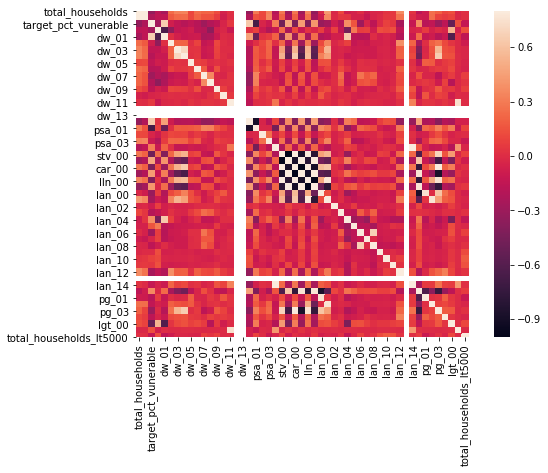

In [23]:
corr = train.corr()
fig = plt.figure(figsize = (9, 6))

sns.heatmap(corr, vmax = .8, square = True)
plt.show()

Text(0.5, 1.0, 'correlation bar_hist')

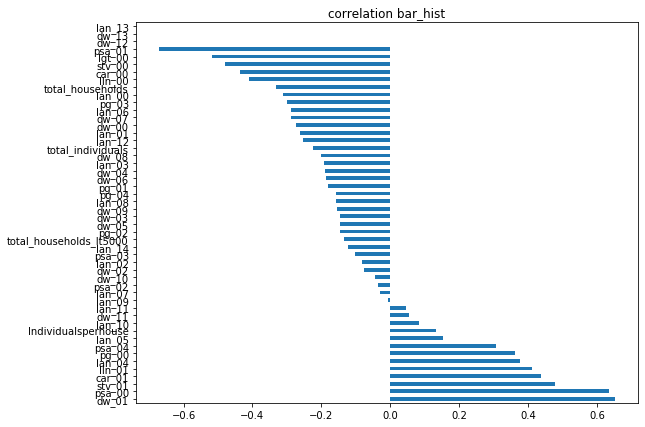

In [24]:
(corr
     .target_pct_vunerable
     .drop("target_pct_vunerable") # can't compare the variable under study to itself
     .sort_values(ascending=False)
     .plot
     .barh(figsize=(9,7)))
plt.title("correlation bar_hist")

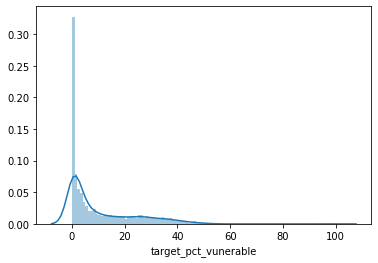

In [25]:
sns.distplot(train.target_pct_vunerable, bins=100)

In [26]:
def rmse(y,x):
    return np.sqrt(mean_squared_error(x,y))


In [27]:
drop_cols = ['target_pct_vunerable', 'ward', 'dw_11', 'dw_12','lan_13']

y = train.target_pct_vunerable
X = train.drop(drop_cols, axis=1)
#X = StandardScaler().fit_transform(X)

ids = test['ward']
test = test.drop(drop_cols[1:], axis=1)
#tt = test[use_cols]

In [28]:
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.03,
    'max_depth': 6,
    'num_leaves': 50, 
    'objective': 'regression',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_val, label=y_val)

lgb_model = lgbm.train(lgb_params, train_data, valid_sets=[train_data, test_data],
                       num_boost_round=9000, early_stopping_rounds=500
                      ) #0.03lr

#lgb_df = lgbm.Dataset(X, y)
#lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=5000)

[1]	training's rmse: 12.7293	valid_1's rmse: 11.9564
Training until validation scores don't improve for 500 rounds
[2]	training's rmse: 12.4394	valid_1's rmse: 11.7093
[3]	training's rmse: 12.1672	valid_1's rmse: 11.4741
[4]	training's rmse: 11.9055	valid_1's rmse: 11.2415
[5]	training's rmse: 11.6547	valid_1's rmse: 11.025
[6]	training's rmse: 11.4083	valid_1's rmse: 10.8051
[7]	training's rmse: 11.1663	valid_1's rmse: 10.5956
[8]	training's rmse: 10.9303	valid_1's rmse: 10.3919
[9]	training's rmse: 10.7014	valid_1's rmse: 10.1916
[10]	training's rmse: 10.4787	valid_1's rmse: 9.99989
[11]	training's rmse: 10.2738	valid_1's rmse: 9.83858
[12]	training's rmse: 10.0665	valid_1's rmse: 9.66284
[13]	training's rmse: 9.8811	valid_1's rmse: 9.50446
[14]	training's rmse: 9.68351	valid_1's rmse: 9.34146
[15]	training's rmse: 9.49914	valid_1's rmse: 9.1865
[16]	training's rmse: 9.31476	valid_1's rmse: 9.02655
[17]	training's rmse: 9.14119	valid_1's rmse: 8.88119
[18]	training's rmse: 8.9746	val

[160]	training's rmse: 3.65821	valid_1's rmse: 5.62229
[161]	training's rmse: 3.65396	valid_1's rmse: 5.62285
[162]	training's rmse: 3.65042	valid_1's rmse: 5.62266
[163]	training's rmse: 3.64428	valid_1's rmse: 5.62337
[164]	training's rmse: 3.63765	valid_1's rmse: 5.62367
[165]	training's rmse: 3.63316	valid_1's rmse: 5.62544
[166]	training's rmse: 3.6301	valid_1's rmse: 5.62622
[167]	training's rmse: 3.62399	valid_1's rmse: 5.62388
[168]	training's rmse: 3.62037	valid_1's rmse: 5.6218
[169]	training's rmse: 3.61619	valid_1's rmse: 5.61967
[170]	training's rmse: 3.6107	valid_1's rmse: 5.61894
[171]	training's rmse: 3.60563	valid_1's rmse: 5.6187
[172]	training's rmse: 3.6023	valid_1's rmse: 5.61773
[173]	training's rmse: 3.59781	valid_1's rmse: 5.61795
[174]	training's rmse: 3.59414	valid_1's rmse: 5.61784
[175]	training's rmse: 3.59153	valid_1's rmse: 5.61747
[176]	training's rmse: 3.58843	valid_1's rmse: 5.61882
[177]	training's rmse: 3.58372	valid_1's rmse: 5.62042
[178]	training'

[327]	training's rmse: 2.97902	valid_1's rmse: 5.62966
[328]	training's rmse: 2.97321	valid_1's rmse: 5.62894
[329]	training's rmse: 2.97164	valid_1's rmse: 5.63013
[330]	training's rmse: 2.96828	valid_1's rmse: 5.62859
[331]	training's rmse: 2.9655	valid_1's rmse: 5.6283
[332]	training's rmse: 2.96338	valid_1's rmse: 5.62788
[333]	training's rmse: 2.96162	valid_1's rmse: 5.62733
[334]	training's rmse: 2.95416	valid_1's rmse: 5.62299
[335]	training's rmse: 2.95179	valid_1's rmse: 5.62517
[336]	training's rmse: 2.94857	valid_1's rmse: 5.6254
[337]	training's rmse: 2.94145	valid_1's rmse: 5.62627
[338]	training's rmse: 2.93848	valid_1's rmse: 5.62569
[339]	training's rmse: 2.9348	valid_1's rmse: 5.62617
[340]	training's rmse: 2.93306	valid_1's rmse: 5.6254
[341]	training's rmse: 2.93184	valid_1's rmse: 5.62629
[342]	training's rmse: 2.92563	valid_1's rmse: 5.6248
[343]	training's rmse: 2.92243	valid_1's rmse: 5.62413
[344]	training's rmse: 2.91917	valid_1's rmse: 5.62505
[345]	training's

[508]	training's rmse: 2.45342	valid_1's rmse: 5.61957
[509]	training's rmse: 2.45144	valid_1's rmse: 5.62027
[510]	training's rmse: 2.4493	valid_1's rmse: 5.62106
[511]	training's rmse: 2.44738	valid_1's rmse: 5.62156
[512]	training's rmse: 2.44583	valid_1's rmse: 5.62267
[513]	training's rmse: 2.44497	valid_1's rmse: 5.62353
[514]	training's rmse: 2.44353	valid_1's rmse: 5.62349
[515]	training's rmse: 2.43893	valid_1's rmse: 5.62304
[516]	training's rmse: 2.43832	valid_1's rmse: 5.62283
[517]	training's rmse: 2.4364	valid_1's rmse: 5.62358
[518]	training's rmse: 2.43473	valid_1's rmse: 5.62296
[519]	training's rmse: 2.43179	valid_1's rmse: 5.62141
[520]	training's rmse: 2.4303	valid_1's rmse: 5.62243
[521]	training's rmse: 2.42805	valid_1's rmse: 5.62215
[522]	training's rmse: 2.42479	valid_1's rmse: 5.62171
[523]	training's rmse: 2.42218	valid_1's rmse: 5.621
[524]	training's rmse: 2.42144	valid_1's rmse: 5.62145
[525]	training's rmse: 2.41942	valid_1's rmse: 5.62167
[526]	training'

[686]	training's rmse: 2.11886	valid_1's rmse: 5.63086
[687]	training's rmse: 2.1174	valid_1's rmse: 5.63099
[688]	training's rmse: 2.11673	valid_1's rmse: 5.63177
[689]	training's rmse: 2.11548	valid_1's rmse: 5.63199
[690]	training's rmse: 2.11497	valid_1's rmse: 5.63243
[691]	training's rmse: 2.11413	valid_1's rmse: 5.63289
[692]	training's rmse: 2.11181	valid_1's rmse: 5.63308
[693]	training's rmse: 2.11086	valid_1's rmse: 5.63316
[694]	training's rmse: 2.1091	valid_1's rmse: 5.63261
[695]	training's rmse: 2.10814	valid_1's rmse: 5.63227
[696]	training's rmse: 2.10719	valid_1's rmse: 5.63293
[697]	training's rmse: 2.1063	valid_1's rmse: 5.63358
[698]	training's rmse: 2.1053	valid_1's rmse: 5.63362
[699]	training's rmse: 2.10284	valid_1's rmse: 5.63291
[700]	training's rmse: 2.1017	valid_1's rmse: 5.63286
[701]	training's rmse: 2.10035	valid_1's rmse: 5.63233
[702]	training's rmse: 2.09959	valid_1's rmse: 5.63212
[703]	training's rmse: 2.09854	valid_1's rmse: 5.63274
[704]	training'

[837]	training's rmse: 1.8913	valid_1's rmse: 5.63571
[838]	training's rmse: 1.89012	valid_1's rmse: 5.63574
[839]	training's rmse: 1.88853	valid_1's rmse: 5.63564
[840]	training's rmse: 1.88706	valid_1's rmse: 5.63533
[841]	training's rmse: 1.88311	valid_1's rmse: 5.63686
[842]	training's rmse: 1.88266	valid_1's rmse: 5.63703
[843]	training's rmse: 1.88119	valid_1's rmse: 5.63721
[844]	training's rmse: 1.8798	valid_1's rmse: 5.63703
[845]	training's rmse: 1.87837	valid_1's rmse: 5.63713
[846]	training's rmse: 1.8781	valid_1's rmse: 5.6374
[847]	training's rmse: 1.87662	valid_1's rmse: 5.63796
[848]	training's rmse: 1.87453	valid_1's rmse: 5.63701
[849]	training's rmse: 1.87338	valid_1's rmse: 5.63683
[850]	training's rmse: 1.87163	valid_1's rmse: 5.63623
[851]	training's rmse: 1.8706	valid_1's rmse: 5.63709
[852]	training's rmse: 1.86932	valid_1's rmse: 5.63582
[853]	training's rmse: 1.86653	valid_1's rmse: 5.63558
[854]	training's rmse: 1.8652	valid_1's rmse: 5.63583
[855]	training's

[1019]	training's rmse: 1.67493	valid_1's rmse: 5.64123
[1020]	training's rmse: 1.67307	valid_1's rmse: 5.64166
[1021]	training's rmse: 1.67222	valid_1's rmse: 5.64148
[1022]	training's rmse: 1.67104	valid_1's rmse: 5.64214
[1023]	training's rmse: 1.66986	valid_1's rmse: 5.64201
[1024]	training's rmse: 1.66935	valid_1's rmse: 5.64193
[1025]	training's rmse: 1.66843	valid_1's rmse: 5.64191
[1026]	training's rmse: 1.66653	valid_1's rmse: 5.64168
[1027]	training's rmse: 1.66552	valid_1's rmse: 5.64178
[1028]	training's rmse: 1.66461	valid_1's rmse: 5.64153
[1029]	training's rmse: 1.66395	valid_1's rmse: 5.64177
[1030]	training's rmse: 1.66296	valid_1's rmse: 5.64115
[1031]	training's rmse: 1.66232	valid_1's rmse: 5.64097
[1032]	training's rmse: 1.66129	valid_1's rmse: 5.64132
[1033]	training's rmse: 1.66042	valid_1's rmse: 5.64131
[1034]	training's rmse: 1.65977	valid_1's rmse: 5.6421
[1035]	training's rmse: 1.65868	valid_1's rmse: 5.64235
[1036]	training's rmse: 1.65753	valid_1's rmse: 5

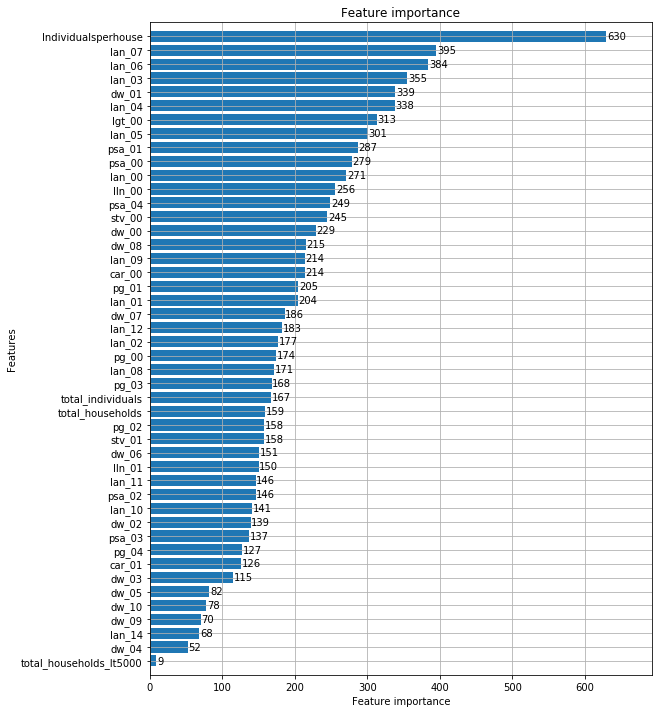

In [29]:
lgbm.plot_importance(lgb_model, height=0.8, figsize=(9,12))

In [40]:
xgb_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.05, n_jobs=-1)
xgb_model.fit(X_train, y_train)

[17:53:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [41]:
val_pred = xgb_model.predict(X_val)
error = rmse(y_val, val_pred)
error

5.886993155417965

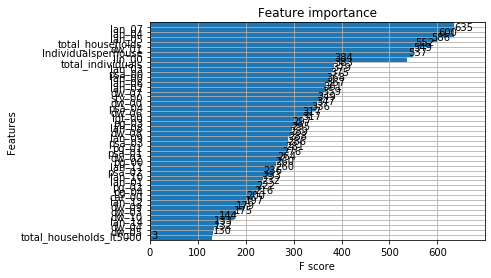

In [32]:
xgb.plot_importance(xgb_model, height=4.0)

In [291]:
# Feature selection
thresholds = np.sort(xgb_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    s_model = xgb.XGBRegressor(n_estimators=2000, learning_rate=0.05, n_jobs=-1)
    s_model.fit(select_X_train, y_train)
    # eval model
    select_X_val = selection.transform(X_val)
    y_pred = s_model.predict(select_X_val)
    val_preds = [round(value) for value in y_pred]
    mse = rmse(y_val, val_preds)
    print("Thresh=%.3f, n=%d, mse: %.2f%" % (thresh, select_X_train.shape[1], mse))

[17:23:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:23:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:23:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=48, Accuracy: 6.67%
[17:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in

In [34]:
# Random-Forest with CV
kf = KFold(n_splits=5, shuffle=False)

scores = []
for train, val in kf.split(X):
  model = RandomForestRegressor(n_estimators=200, max_depth=5, n_jobs=-1,
                                random_state=42)
  model.fit(X.iloc[train], y.iloc[train])
  root_mse = rmse(y.iloc[val], model.predict(X.iloc[val]))
  scores.append(root_mse)
  print(root_mse)

print("Average score in 5-fold CV:", np.mean(scores))

6.699359761733597
7.103906234648525
6.366038793740583
6.479992588702378
6.048082461706889
Average score in 5-fold CV: 6.5394759681063945


In [35]:
predictions = xgb_model.predict(test)
preds = lgb_model.predict(test)

In [38]:
sub['ward'] = ids
sub['target_pct_vunerable'] = preds
sub.head()

,ward,target_pct_vunerable
0,00A93O0,17.302237
1,01V40KO,35.041904
2,01ZHVW0,4.495542
3,028YQJX,0.341453
4,02G8W11,-1.576602


In [39]:
#%mkdir submissions
#sub.to_csv(f'./submissions/sub{np.round(np.mean(scores), 4)}.csv', index=False)
sub.to_csv('./submissions/lgbm_sub.csv', index=False)
#sub.to_csv('./submissions/xgb_sub.csv', index=False)